<a href="https://colab.research.google.com/github/APre203/MLTopic1/blob/main/StutterClassification-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install pydub

### Downloaded Full Audio Files

In [3]:
import os
import pathlib
import requests
# from pydub import AudioSegment
from pydub import AudioSegment
import numpy as np
import argparse

def wav_converter(episodes, wavs):

  episode_uri = episodes
  wav_dir = wavs

  # Load episode data
  table = np.loadtxt(episode_uri, dtype=str, delimiter=',')

  urls = table[:, 2]
  n_items = len(urls)

  audio_types = [".mp3", ".m4a", ".mp4"]

  for i in range(n_items):
      # Get show/episode IDs
      show_abrev = table[i, -2].strip()
      ep_idx = table[i, -1]
      episode_url = table[i, 2]
      # print(episode_url, ep_idx, show_abrev) # (https://media.talkbank.org/fluency/Voices-AWS/interview/46ma.mp4  010  FluencyBank)

      # Check file extension
      ext = ''
      for ext in audio_types:
          if ext in episode_url:
              break

      # Ensure the base folder exists for this episode
      episode_dir = pathlib.Path(f"{wav_dir}/{show_abrev}/")
      # print(episode_dir)
      os.makedirs(episode_dir, exist_ok=True)

      # Get file paths
      audio_path_orig = pathlib.Path(f"{episode_dir}/{ep_idx}{ext}")
      wav_path = pathlib.Path(f"{episode_dir}/{ep_idx}.wav")
      # print(audio_path_orig, wav_path) #"C:\Users\andrew\Downloads\ml-stuttering-events-dataset\wav\ FluencyBank\ 010.mp4"

      # Download raw audio file
      if not os.path.exists(audio_path_orig):
          response = requests.get(episode_url)
          with open(audio_path_orig, 'wb') as audio_file:
              audio_file.write(response.content)

      # Convert to 16khz mono wav file
      # print(audio_path_orig)
      audio = AudioSegment.from_file(audio_path_orig) #error here
      audio = audio.set_frame_rate(16000).set_channels(1)
      audio.export(wav_path, format="wav")

      os.remove(audio_path_orig)

In [52]:
wav_converter("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_episodes2.csv", "wav")

### Divided Audio Files Into 3 Second Clips

In [64]:

import os
import pathlib
import subprocess

import numpy as np
import pandas as pd
from scipy.io import wavfile

import argparse
def clip_maker(labels, wavs, clips):

  label_file = labels
  data_dir = wavs
  output_dir = clips


  # Load label/clip file
  data = pd.read_csv(label_file, dtype={"EpId":str})

  # Get label columns from data file
  shows = data.Show
  episodes = data.EpId
  clip_idxs = data.ClipId
  starts = data.Start
  stops = data.Stop
  labels = data.iloc[:,5:].values

  n_items = len(shows)

  loaded_wav = ""
  cur_iter = range(n_items)
  for i in cur_iter:
    clip_idx = clip_idxs[i]
    show_abrev = shows[i]
    episode = episodes[i].strip()

    # Setup paths
    wav_path = f"{data_dir}/{shows[i]}/{episode}.wav"
    # print(wav_path)
    clip_dir = pathlib.Path(f"{output_dir}/{show_abrev}/{episode}/")
    clip_path = f"{clip_dir}/{shows[i]}_{episode}_{clip_idx}.wav"

    if not os.path.exists(wav_path):
      print("Missing", wav_path)
      continue

    # Verify clip directory exists
    os.makedirs(clip_dir, exist_ok=True)

    # Load audio. For efficiency reasons don't reload if we've already open the file.
    if wav_path != loaded_wav:
      sample_rate, audio = wavfile.read(wav_path)
      assert sample_rate == 16000, "Sample rate must be 16 khz"

      # Keep track of the open file
      loaded_wav = wav_path

    # Save clip to file
    clip = audio[starts[i]:stops[i]]
    wavfile.write(clip_path, sample_rate, clip)


In [53]:
clip_maker("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels2.csv", "wav", "clips")

### Building Model Section / Preprocessing

In [102]:
import librosa
import librosa.feature
import soundfile as sf
# p = "/content/clips/FluencyBank/10/"
def mel_spectrogram(filename, path):
  # try:
    y, sr = sf.read(path + filename)

    mfccs = mfcc_converter(y, sr)

    # y, sr = librosa.load(path + filename)
    window_size = 1024
    hop_length = 256

    # Calculate time_steps and frequency_bins
    time_steps = int((len(y) - window_size) / hop_length) + 1
    frequency_bins = window_size // 2

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=window_size, hop_length=hop_length)

    return [mel_spectrogram, mfccs]
  # except:
  #   return None

def mfcc_converter(audio, sr):
  # Compute MFCCs
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
  return mfccs

csv_file = "/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels2.csv"
csv_df = pd.read_csv(csv_file, delimiter=",", encoding='utf-8')

def file_to_df(csv, numb, clip_filename):

  # new_df = pd.DataFrame(columns=df.columns)  # Create an empty DataFrame
  new_df = pd.DataFrame(columns=csv_df.columns)
  n = 0  # Initialize a counter
  for index, row in csv.iterrows():
    # if n == numb:

    #     break  # Stop when n reaches the desired number
    path_name = f'{row["Show"]}_{row["EpId"]}_{row["ClipId"]}.wav'
    p = f'/content/{clip_filename}/FluencyBank/{row["EpId"]}/'
    both = mel_spectrogram(path_name, p)
    spectro, mfcc = both[0], both[1]
    if spectro is not None:
      if row["NoStutteredWords"] >= 2:
        row["Stutter"] = 0 # didnt stutter
      else:
        row["Stutter"] = 1 # did stutter
      row["spect"] = spectro
      row["mfcc"] = mfcc
      new_df = new_df.append(row, ignore_index=True)  # Append the new row to the new DataFrame TRY CHANGEING IT TO pd.concat
      retval_df = new_df
      # if n == 0:

      #   print(row)
      #   print(new_df)
      #   n+= 1
      # retval_df = pd.concat([row,new_df])
      # n += 1  # Increment the counter
  return retval_df

In [ ]:
# print(mel_spectrogram("FluencyBank_10_0.wav",p))
csv_sample = file_to_df(csv_df,0, "clips")

In [104]:
import cv2
width, height = 128, 128

resized_spectrograms = []
resized_mfccs = []

for spectrogram,mfcc in zip(csv_sample["spect"], csv_sample["mfcc"]):
    # Resizing spectrogram to the desired shape (128x128)
    resized_spectrogram = cv2.resize(spectrogram, (width, height))
    resized_spectrograms.append(resized_spectrogram)
    resized_mfcc = cv2.resize(mfcc, (width, height))
    resized_mfccs.append(resized_mfcc)

data = np.array(resized_mfccs) #trying with mfcc
labels = np.array(csv_sample["Stutter"]) # 0 -> didnt, 1 -> did

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [106]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build a CNN model
model = models.Sequential([
    layers.Input(shape=(height, width, 1)),  # Input shape matches the resized spectrogram dimensions
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 output classes: stutter and not-stutter
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=18, validation_data=(X_test, y_test))

model.save("/content/drive/MyDrive/stutter_model.h5")

Epoch 1/18
66/66 [==============================] - 27s 401ms/step - loss: 17.5898 - accuracy: 0.5663 - val_loss: 1.4710 - val_accuracy: 0.5363
Epoch 2/18
66/66 [==============================] - 24s 368ms/step - loss: 1.4113 - accuracy: 0.6422 - val_loss: 1.7139 - val_accuracy: 0.4962
Epoch 3/18
66/66 [==============================] - 26s 389ms/step - loss: 1.0978 - accuracy: 0.6789 - val_loss: 1.2522 - val_accuracy: 0.5821
Epoch 4/18
66/66 [==============================] - 25s 384ms/step - loss: 0.7884 - accuracy: 0.7214 - val_loss: 2.0867 - val_accuracy: 0.5782
Epoch 5/18
66/66 [==============================] - 23s 349ms/step - loss: 0.6427 - accuracy: 0.7681 - val_loss: 1.1942 - val_accuracy: 0.6107
Epoch 6/18
66/66 [==============================] - 25s 378ms/step - loss: 2.9905 - accuracy: 0.6837 - val_loss: 1.3135 - val_accuracy: 0.5496
Epoch 7/18
66/66 [==============================] - 26s 396ms/step - loss: 1.1487 - accuracy: 0.7457 - val_loss: 1.1908 - val_accuracy: 0.572

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Converting Test Cases

In [36]:
wav_converter("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_episodes_test.csv", "test")
clip_maker("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels_test.csv", "test", "test_clips")

### Testing Test Cases

In [47]:
def didnt_or_did(n1,n2): # 0 for noStutter 1 for Stutter
  if n1 > n2:
    return 0
  return 1

In [ ]:
test_file = "/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels_test.csv"
test_df = pd.read_csv(test_file, delimiter=",", encoding='utf-8')
test_sample = file_to_df(test_df, 0, "test_clips") #2nd parameter doesnt matter total tests about 600 results

In [ ]:
y_true = []
y_pred = []
for s, m, g in zip(test_sample["spect"], test_sample["mfcc"], test_sample["Stutter"]):
  width, height = 128, 128
  resized_spectrogram = cv2.resize(s, (width, height))
  resized_mfcc = cv2.resize(m, (width, height))

  prediction = model.predict(np.expand_dims(resized_mfcc, axis=0)) #testing mfcc

  y_true.append(g)
  y_pred.append(didnt_or_did(prediction[0][0],prediction[0][1]))


In [109]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true, y_pred)

print(confusion) #[[TP, FP][FN, TN]]

[[340 151]
 [351 226]]


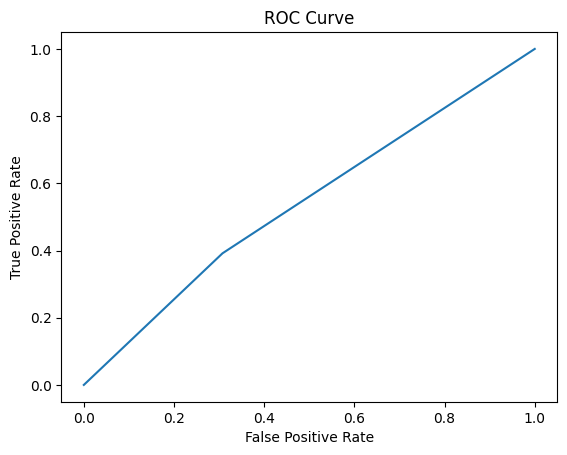

In [110]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()